**Notas para contenedor de docker:**

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

```
docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_numerical -p 8888:8888 -p 8786:8786 -p 8787:8787 -d palmoreck/jupyterlab_numerical:1.1.0
```

password para jupyterlab: `qwerty`

Detener el contenedor de docker:

```
docker stop jupyterlab_numerical
```


Documentación de la imagen de docker `palmoreck/jupyterlab_numerical:1.1.0` en [liga](https://github.com/palmoreck/dockerfiles/tree/master/jupyterlab/numerical).

---

Esta nota utiliza métodos vistos en [1.5.Integracion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.5.Integracion_numerica.ipynb)

**Con la siguiente celda instalamos paquetes desde jupyterlab.** Ver [liga](https://ipython.readthedocs.io/en/stable/interactive/magics.html#built-in-magic-commands) para magic commands.

In [2]:
%%bash
sudo apt-get install -y -qq graphviz

In [3]:
%pip install -q --user graphviz

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


La siguiente celda reiniciará el kernel de **IPython** para cargar los paquetes instalados en la celda anterior. Dar **Ok** en el mensaje que salga y continuar con el contenido del notebook.

In [4]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

{'status': 'ok', 'restart': True}

# Dask

Documentación en: [dask](https://docs.dask.org/en/latest/), [dask-github](https://github.com/dask/dask/), [blog](http://matthewrocklin.com/blog/).

## ¿Qué es y qué nos ofrece?

* Librería para cómputo en paralelo, en específico ayuda al procesamiento en sistemas de memoria compartida o distribuida. Ver [2.2.Sistemas_de_memoria_compartida](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.2.Sistemas_de_memoria_compartida.ipynb).

* Extiende interfaces de arrays, dataframes y listas usadas en `numpy`, `pandas` e `iterators` para el procesamiento en paralelo y manejo de *datasets* que no caben en la memoria RAM: *larger than memory datasets*. En el contexto de dask a los tipos de datos anteriores les denomina **big data collections**. Entonces las *big data collections* soportadas por `dask` son alternativas a los arrays y dataframes de `numpy` y `pandas` para grandes datasets y ejecución en paralelo de **algunas funciones** de éstos paquetes.

* Soporta un task scheduling* dinámico* y optimizado para cómputo*.

\*Task scheduling es un enfoque de paralelización (ver [2.1.Un_poco_de_historia_y_generalidades](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.1.Un_poco_de_historia_y_generalidades.ipynb)) en el que dividimos el programa en muchos *tasks medium-sized*. En `dask` se representan tales tasks como nodos de un grafo con líneas entre éstos si un task depende de lo producido por otro. 

\*Dinámico pues las [task graphs](https://docs.dask.org/en/latest/graphs.html) pueden ser definidas a partir de las *big data collections* o por users.

\*Optimizado para cómputo pues en *dask* existen [task schedulers](https://docs.dask.org/en/latest/scheduling.html) para ejecutar en paralelo (o secuencial) la *task graph*.

* Soporta el enfoque de paralelización de datos (ver [2.1.Un_poco_de_historia_y_generalidades](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.1.Un_poco_de_historia_y_generalidades.ipynb)) con las *collections*: [dask arrays](https://docs.dask.org/en/latest/array.html), [dask dataframes](https://docs.dask.org/en/latest/dataframe.html) y [dask bags](https://docs.dask.org/en/latest/bag.html).

## ¿Cómo se implementan una task y una task graph en dask?

Cada *task* se implementa como un *tuple* de Python que contiene funciones y argumentos de las mismas:

In [1]:
def fun_suma(arg1,arg2):
    return arg1+arg2

t = (fun_suma,-1,2) #tuple, también puede usarse así: t = tuple([fun,-1,2])

In [2]:
t

(<function __main__.fun_suma(arg1, arg2)>, -1, 2)

Una *task graph* se implementa como un diccionario de *tasks*:

In [3]:
diccionario = {'arg1': -1,
               'arg2': 2,
               'resultado': (fun_suma, 'arg1', 'arg2')}

y a este diccionario de tasks se le llama *dask graph*.

**Comentario:** dask posee módulos para optimizar la ejecución de las *task graphs* (ver [optimization](https://docs.dask.org/en/latest/optimize.html))

## ¿Cómo ejecutamos la *dask graph*?

In [4]:
import dask

Con los *schedulers* definidos en dask. Ver [Scheduling](https://docs.dask.org/en/latest/scheduling.html) y [Scheduler Overview](https://docs.dask.org/en/latest/scheduler-overview.html)

Para cualquier *scheduler* definido en dask el *entry point* es una función *get* la cual recibe una *dask graph* y una *key* o lista de *keys* para cálculos:

In [5]:
dask.get(diccionario,'resultado') #synchronous scheduler 

1

In [6]:
dask.threaded.get(diccionario,'resultado') #scheduler backed by a thread pool

1

In [7]:
dask.multiprocessing.get(diccionario,'resultado') #scheduler backed by a process pool

1

**Comentarios:** 

* La función `dask.get` ejecuta con un `synchronous scheduler` el cual sólo utiliza un thread de ejecución sin paralelización. Útil para *debugging* y perfilamiento.

* La función `dask.threaded.get` ejecuta con un *scheduler* `multiprocessing.pool.ThreadPool`. Como el nombre lo indica, se hacen `fork`'s y `join`'s de un proceso. El overhead para ejecución es pequeño y no hay costo en transferencia de datos entre los *taks*. Sin embargo debido al *GIL* de Python, este scheduler provee paralelización si tu código es esencialmente "no Python", por ejemplo si utilizas código de `numpy` o `pandas` o `cython`. Ver [2.2.Python_multiprocessing](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.2.Python_multiprocessing.ipynb) y [1.7.Compilar_a_C_Cython](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.7.Compilar_a_C_Cython.ipynb).

* La función `dask.multiprocessing.get` ejecuta con un *scheduler* `multiprocessing.Pool`. Ver [2.2.Python_multiprocessing](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.2.Python_multiprocessing.ipynb). Se crean para cada *task* un proceso, no tiene problemas del *GIL* de Python para código Python, sin embargo, mover datos hacia procesos y de vuelta al proceso principal tiene costos altos. Útil para *tasks* que no requieren mucha transferencia de datos y cuando los inputs y outputs son pequeños.

**Comentario:** en la documentación de `dask` se recomienda utilizar al *scheduler distributed*, documentación en [Dask.distributed](https://distributed.dask.org/en/latest/), en lugar de usar `dask.multiprocesing.get`. Para una pequeña explicación ver [Dask Distributed](https://docs.dask.org/en/latest/scheduling.html#dask-distributed-local).


## ¿Cómo visualizamos la *task graph*?

Usamos `visualize`, ver por ejemplo: [Visualize task graphs](https://docs.dask.org/en/latest/graphviz.html) y [dask.visualize](https://docs.dask.org/en/latest/api.html#dask.visualize).

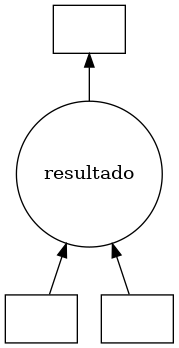

In [8]:
dask.visualize(diccionario,'resultado')

Las cajas representan datos, los círculos representan funciones que se ejecutan sobre tales datos y las flechas especifican cuáles funciones producen/consumen qué datos.

## En resumen en dask seguimos un flujo como el siguiente dibujo:

<img src="https://docs.dask.org/en/latest/_images/dask-overview.svg" heigth="400" width="400">

**y para crear task graphs podemos partir de las *collections* o bien, definir nuestras propias *dask graphs*.**

**Comentario**: si trabajamos con las *collections* será extraño que trabajemos a nivel de funciones `get`. Cada *collection* tiene un default scheduler y una función [compute](https://docs.dask.org/en/latest/scheduler-overview.html#using-compute-methods) que calcula el output de la *collection*:

## Ejemplo:

[dask arrays](https://docs.dask.org/en/latest/array.html) y [dask dataframes](https://docs.dask.org/en/latest/dataframe.html) utilizan al *threaded scheduler* por default pero con `compute` puede cambiarse de *scheduler*:

In [9]:
import dask.array as da

In [10]:
x = da.arange(100)

In [11]:
x

dask.array<arange, shape=(100,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

In [12]:
type(x)

dask.array.core.Array

Llamamos a la función [dask.compute](https://docs.dask.org/en/latest/api.html#dask.compute). Por default para el *dask array* utiliza el *threaded scheduler* para la ejecución de la *dask graph* asociada:

In [13]:
x.sum().compute()

4950

Podemos cambiar de *scheduler* con *compute*:

In [14]:
x.sum().compute(scheduler='processes')

4950

**Comentario:** por default `dask` trabaja con *chunks*. En el ejemplo pasado no definimos, pero podemos hacer:

In [15]:
x = da.arange(100, chunks=10)

In [16]:
x

dask.array<arange, shape=(100,), dtype=int64, chunksize=(10,), chunktype=numpy.ndarray>

**Comentario:** también por *default*, `dask` trabaja de una forma *lazy*, esto es, `dask` no calculará ningún resultado hasta que explícitamente se le dé la instrucción. Por ejemplo, podemos hacer:

In [17]:
y = x.sum()

In [18]:
y

dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>

y hasta ahora no se ha calculado la suma (cuyo resultado es un escalar). Después de llamar a `compute` se ejecuta la *task graph* para ejecución en paralelo (si se definió al *scheduler* para este tipo de ejecución):

In [19]:
y.compute()

4950

Y podemos visualizar la *task graph* definida en `y` que es un *dask array*:

In [20]:
type(y)

dask.array.core.Array

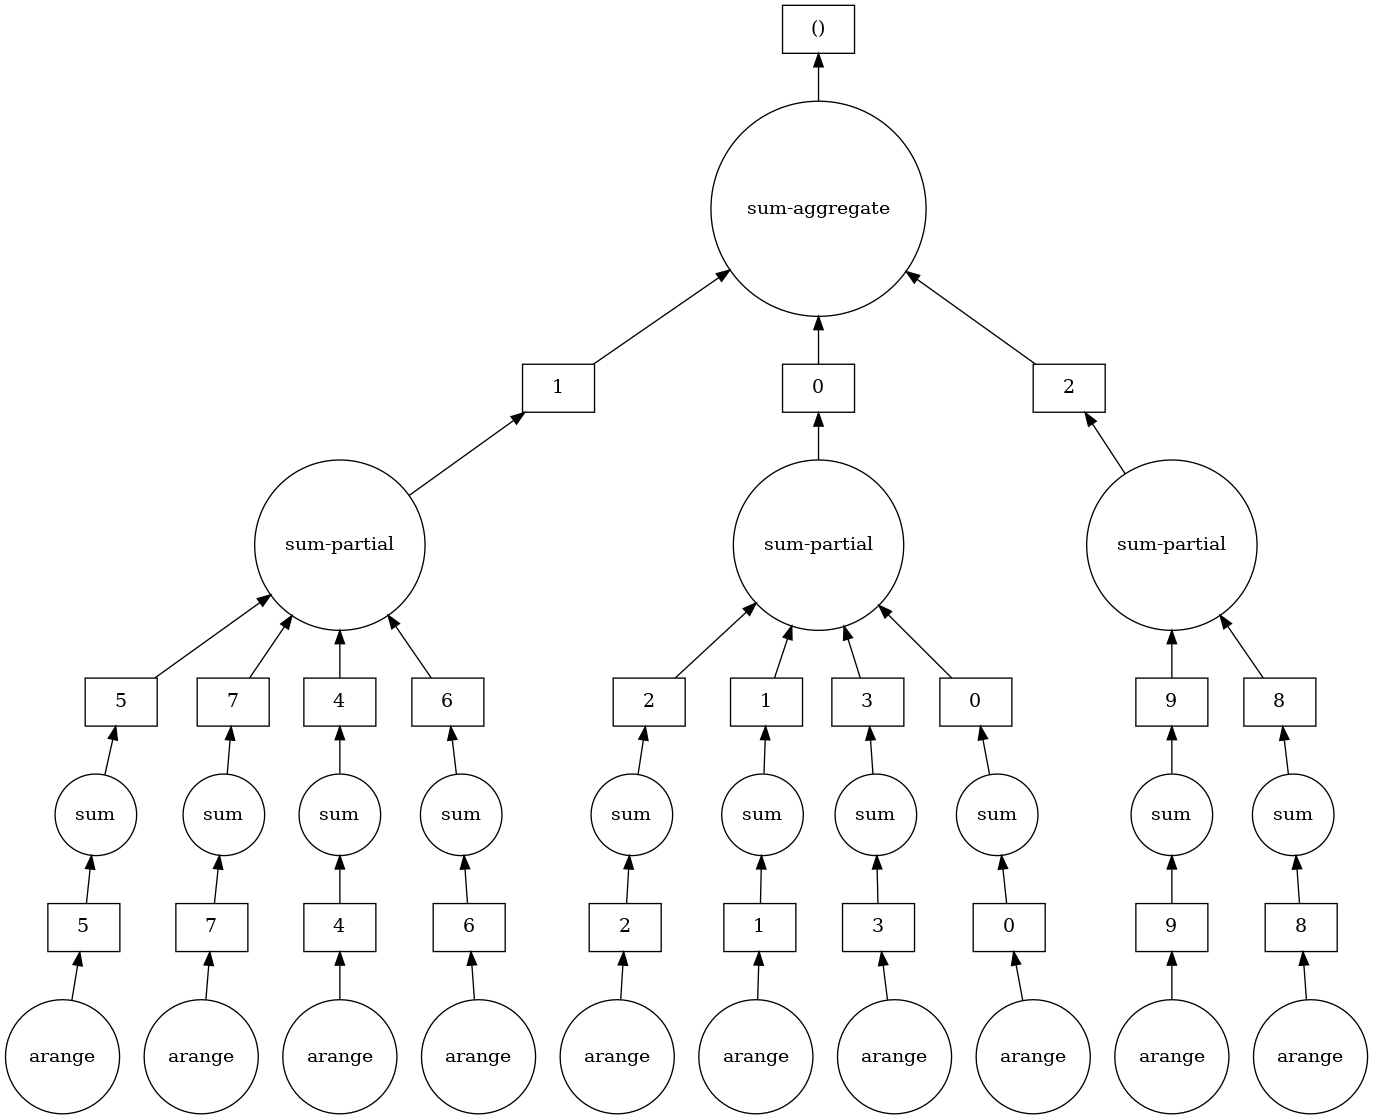

In [21]:
y.visualize()

Ver la API de *dask array* en [array api](https://docs.dask.org/en/latest/array-api.html) para más funcionalidad.

**Comentario:** también `dask` tiene una función [compute](https://docs.dask.org/en/latest/scheduler-overview.html#the-compute-function) más general que toma múltiples *collections* y regresa múltiples resultados. Esto combina grafos de cada *collection* de modo que resultados intermedios son compartidos. Por ejemplo:

In [22]:
y = (x+1).sum()
z = (x+1).mean()

In [23]:
da.compute(y, z)

(5050, 50.5)

y aquí el resultado intermedio `x+1` sólo fue calculado una vez. Si hubiéramos hecho:

```
y.compute()
z.compute()
```

el resultado intermedio `x+1` hubiera sido calculado dos veces. Ésta función `compute` trabaja sobre cualquier *collection* y se encuentra en `dask.base`:

In [24]:
from dask.base import compute

In [25]:
compute is da.compute

True

In [26]:
compute(y,z)

(5050, 50.5)

También se puede especificar para el scheduler `threaded` o `multiprocessing` el número de workers en `compute`:

In [27]:
y.compute(num_workers=2)

5050

Ver [configuration](https://docs.dask.org/en/latest/scheduling.html#configuration) para otras formas de especificar al `scheduler`.

## Dask distributed

Esta librería tiene una documentación en un proyecto externo al de dask y se puede encontrar en [Dask.distributed](https://distributed.dask.org/en/latest/).

Es una librería que extiende a [concurrent.features](https://docs.python.org/3/library/concurrent.futures.html) (`multiprocessing` es similar a `concurrent.features`) y a `dask` a clústers de tamaño mediano (alrededor de cientos de máquinas).

Aunque el nombre *distributed* puede pensarse como que la ejecución sólo puede llevarse a cabo en clústers de máquinas, también puede utilizarse en nuestra máquina local. Por razones como proveer acceso a una API asíncrona: [Futures](https://docs.dask.org/en/latest/futures.html), acceso a un *dashboard* diagnóstico y manejar mejor la *data locality* con múltiples procesos más eficientemente que con `dask.multiprocessing.get`, representa una **alternativa fuerte** a la generación de procesos locales vía `dask.multiprocessing`: "The distributed scheduler described a couple sections below is often a better choice today than `dask.multiprocessing`..."

Satisface las siguientes características:

* Low latency: Each task suffers about 1ms of overhead. A small computation and network roundtrip can complete in less than 10ms.
* Peer-to-peer data sharing: Workers communicate with each other to share data. This removes central bottlenecks for data transfer.
* Complex Scheduling: Supports complex workflows (not just map/filter/reduce) which are necessary for sophisticated algorithms used in nd-arrays, machine learning, image processing, and statistics.
* Data Locality: Scheduling algorithms cleverly execute computations where data lives. This minimizes network traffic and improves efficiency.
* Familiar APIs: Compatible with the [concurrent.futures](https://www.python.org/dev/peps/pep-3148/) API in the Python standard library. Compatible with dask API for parallel algorithms

Para ver más sobre el `distributed scheduler` ver [architecture](https://distributed.dask.org/en/latest/#architecture).

### Client

El [Client](https://distributed.dask.org/en/latest/client.html) es el *entry point* para users de `dask.distributed`. Creamos un *distributed scheduler* al importar `Client`. Esta acción *override* cualquier configuración que se haya hecho del *scheduler*.

In [28]:
from dask.distributed import Client
import multiprocessing

In [29]:
client = Client(n_workers=multiprocessing.cpu_count(),
                threads_per_worker=1
               )   

In [30]:
client

Client Scheduler: tcp://127.0.0.1:46031 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 6.25 GB


Al dar click en el `dashboard` de arriba se mostrará la página de `status` mediante [bokeh](https://docs.bokeh.org/en/latest/index.html) (si corre éste notebook en un docker, revisar a qué puerto está mapeado el de `8787`):

<img src="https://dl.dropboxusercontent.com/s/n5i7r4tp0saffmx/dask_1.png?dl=0" heigth="500" width="500">

y en el apartado de `workers`:

<img src="https://dl.dropboxusercontent.com/s/aqspobw9mmtw1tw/dask_2.png?dl=0" heigth="500" width="500">

**Comentario:** La línea anterior que contiene `Client()`, configura un *scheduler* en el proceso local y varios procesos *workers* que corren con un thread de ejecución. Si se desea que los procesos *worker* estén contenidos en el proceso local puede usarse `Client(processes=False)`. Si nuestros cálculos están soltando el *GIL* y se desea evitar comunicación  *inter worker* entonces lo anterior es recomendable usar `Client(processes=False)`.

Algunas opciones que pueden utilizarse en la línea de `Client` son:

* `Client(n_workers=4)`.

* `Client(threads_per_worker=2)`.

* `Client(memory_limit='10GB')`.

# Regla del rectángulo

In [31]:
import math
import time
from scipy.integrate import quad

In [32]:
f=lambda x: math.exp(-x**2)
a=0
b=1
n=10**6
h_hat=(b-a)/n

**Forma secuencial**

In [33]:
def Rcf(f, a, b, n): #Rcf: rectángulo compuesto para f
    """
    Compute numerical approximation using rectangle or mid-point method in 
    an interval.
    Nodes are generated via formula: x_i = a+(i+1/2)h_hat for i=0,1,...,n-1 and h_hat=(b-a)/n
    Args:
        f (lambda expression): lambda expression of integrand
        a (int): left point of interval
        b (int): right point of interval
        n (int): number of subintervals
    Returns:
        Rcf (float) 
    """
    h_hat=(b-a)/n
    suma_res=0
    for i in range(0,n):
        x=a+(i+1/2.0)*h_hat
        suma_res+=f(x)
    return h_hat*suma_res


In [34]:
start_time = time.time()
aprox=Rcf(f,a,b,n)
end_time = time.time()

In [35]:
secs = end_time-start_time
print("Rcf tomó",secs,"segundos" )

Rcf tomó 0.4465188980102539 segundos


In [36]:
obj, err = quad(f, a, b)

In [37]:
def err_relativo(aprox, obj):
    return math.fabs(aprox-obj)/math.fabs(obj) #obsérvese el uso de la librería math

In [38]:
err_relativo(aprox,obj)

6.71939731300312e-14

In [39]:
Rcf_secuencial_timeit = %timeit -n 5 -r 10 -o Rcf(f,a,b,n)

429 ms ± 6.72 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [40]:
Rcf_secuencial_timeit.average

0.42912459069862957

**Forma en paralelo**

In [41]:
p=multiprocessing.cpu_count()
ns_p = int(n/p) #número de subintervalos por proceso
                #se asume que n es divisible por p
                #si no se cumple esto, se puede definir 
                #ns_p=int(n/p) habiendo definido n primero
                #y redefinir n como: 
                #n=p*ns_p

In [42]:
def construye_nodos_en_subintervalos(mi_id,a,b,h_hat,n,ns_p):
    begin=mi_id*ns_p
    end=begin+ns_p
    h_hat=(b-a)/n
    nodos = []
    for i in range(begin,end):
        nodos.append(a+(i+1/2.0)*h_hat)
    return nodos

In [43]:
def evalua_f_en_nodos_y_suma(nodos,f):
    suma_res = 0
    for nodo in nodos:
        suma_res+=f(nodo)
    return suma_res

In [44]:
futures_nodos = client.map(construye_nodos_en_subintervalos,range(p),
                                                            **{'a':a,
                                                               'b':b,
                                                               'h_hat':h_hat,
                                                               'n':n,
                                                               'ns_p':ns_p}
                            )

In [45]:
futures_evalua = client.map(evalua_f_en_nodos_y_suma, futures_nodos,
                                                       **{'f':f}
                            )

In [46]:
results = client.gather(futures_evalua)

In [47]:
aprox=h_hat*sum(results)

In [48]:
err_relativo(aprox,obj)

3.2556371936895645e-14

In [49]:
%%timeit -n 5 -r 10 -o
results = client.gather(futures_evalua)
aprox=h_hat*sum(results)

6.55 ms ± 1.09 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


<TimeitResult : 6.55 ms ± 1.09 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)>

In [50]:
Rcf_parallel_timeit=_

In [51]:
Rcf_parallel_timeit.average

0.006551557052880526

Usando result de futures:

In [71]:
client.close()

In [72]:
client = Client(n_workers=multiprocessing.cpu_count(),
                threads_per_worker=1
               )  

In [73]:
futures_nodos = client.map(construye_nodos_en_subintervalos,range(p),
                                                            **{'a':a,
                                                               'b':b,
                                                               'h_hat':h_hat,
                                                               'n':n,
                                                               'ns_p':ns_p}
                            )

In [74]:
futures_evalua = client.map(evalua_f_en_nodos_y_suma, futures_nodos,
                                                       **{'f':f}
                            )

In [75]:
%%timeit -n 5 -r 10 -o
results = [future.result() for future in futures_evalua]
aprox = h_hat*sum(results)

17 ms ± 1.24 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


<TimeitResult : 17 ms ± 1.24 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)>

In [76]:
Rcf_parallel_timeit2=_

In [77]:
Rcf_parallel_timeit2.average

0.016950907479040326

## Gráfica de tiempo de ejecución vs número de procesos

In [57]:
err_np=[]
n_cpus=[]

In [58]:
def Rcf_parallel(mi_id,f,a,b,h_hat,n,ns_p):
    begin=mi_id*ns_p
    end=begin+ns_p
    h_hat=(b-a)/n
    suma_res = 0
    for i in range(begin,end):
        x=a+(i+1/2.0)*h_hat
        suma_res+=f(x)
    return suma_res

In [59]:
def mifun(p,ns_p):
    client = Client(n_workers=p,
                    threads_per_worker=1
                   )
    features_Rcf_parallel = client.map(Rcf_parallel,range(p),
                                             **{'f':f,
                                                'a':a,
                                                'b':b,
                                                'h_hat':h_hat,
                                                'n':n,
                                                'ns_p':ns_p}
                              ) 
    results = client.gather(features_Rcf_parallel)
    client.close()
    aprox = h_hat*sum(results)
    return err_relativo(aprox,obj)

In [60]:
client.close()

In [61]:
for p in range(1,multiprocessing.cpu_count()+1):
    if n%p==0:
        ns_p=int(n/p)
        err_np.append(mifun(p,ns_p))
        n_cpus.append(p)

In [62]:
err_np

[6.71939731300312e-14,
 5.842307840730588e-14,
 4.816559135869493e-14,
 5.024682061493483e-14,
 3.2556371936895645e-14]

In [63]:
n_cpus

[1, 2, 4, 5, 8]

In [64]:
l=[]
n_cpus=[]

In [65]:
client.close()

In [66]:
for p in range(1,multiprocessing.cpu_count()+1):
    if n%p==0:
        ns_p=int(n/p)
        resultado_timeit=%timeit -n 5 -r 5 -o mifun(p,ns_p)
        l.append(resultado_timeit.average)
        n_cpus.append(p)

1.73 s ± 12.2 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
1.53 s ± 14.7 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
1.52 s ± 14.6 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
1.56 s ± 5.28 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
1.7 s ± 10.4 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [67]:
l

[1.7262007333990188,
 1.5342405076790602,
 1.521511250184849,
 1.5643970063887536,
 1.704913247320801]

In [68]:
n_cpus

[1, 2, 4, 5, 8]

In [69]:
import matplotlib.pyplot as plt

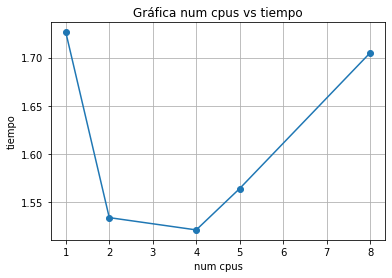

In [70]:
plt.plot(n_cpus,l,'o-')
plt.title('Gráfica num cpus vs tiempo')
plt.xlabel('num cpus')
plt.ylabel('tiempo')
plt.grid()
plt.show()

In [78]:
client.close()

In [110]:
n=10**4
h_hat = (b-a)/n

In [111]:
def construye_nodos(i):
    return a+(i+1/2)*h_hat

In [118]:
futures_construye_nodos = client.map(construye_nodos, range(n), pure=False)

In [119]:
def f_eval(node):
    return f(node)

In [120]:
futures_f_eval = client.map(f_eval, futures_construye_nodos, pure=False)

In [121]:
results = client.gather(futures_f_eval)

In [122]:
aprox = h_hat*sum(results)

In [123]:
err_relativo(aprox,obj)

4.104902117398494e-10

In [70]:
p=4
ns_p = int(n/p)

In [71]:
def construye_nodos_en_subintervalos(mi_id,a,b,h_hat,n,ns_p):
    begin=mi_id*ns_p
    end=begin+ns_p
    h_hat=(b-a)/n
    nodos = []
    for i in range(begin,end):
        nodos.append(a+(i+1/2.0)*h_hat)
    return nodos

In [78]:
def evalua_f_en_nodos_y_suma(nodos,f):
    suma_res = 0
    for nodo in nodos:
        suma_res+=f(nodo)
    return suma_res

In [79]:
futures_nodos = client.map(construye_nodos_en_subintervalos,range(p),
                                                            **{'a':a,
                                                               'b':b,
                                                               'h_hat':h_hat,
                                                               'n':n,
                                                               'ns_p':ns_p}
                            )

In [80]:
futures_evalua = client.map(evalua_f_en_nodos_y_suma, futures_nodos,
                                                       **{'f':f}
                            )

In [81]:
results = client.gather(futures_evalua)

In [82]:
aprox=h_hat*sum(results)

In [83]:
err_relativo(aprox,obj)

4.816559135869493e-14

Usando result de futures:

In [84]:
futures_nodos = client.map(construye_nodos_en_subintervalos,range(p),
                                                            **{'a':a,
                                                               'b':b,
                                                               'h_hat':h_hat,
                                                               'n':n,
                                                               'ns_p':ns_p}
                            )

In [85]:
futures_evalua = client.map(evalua_f_en_nodos_y_suma, futures_nodos,
                                                       **{'f':f}
                            )

In [87]:
%%timeit -n 5 -r 10 -o
results = [future.result() for future in futures_evalua]
aprox = h_hat*sum(results)

CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 49.1 ms


In [ ]:
Rcf_parallel_timeit=_

In [88]:
client.close()

In [89]:
client

Client Scheduler: tcp://127.0.0.1:34523 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


https://docs.dask.org/en/latest/scheduler-overview.html

distributed.Client.get: a distributed scheduler for executing graphs
    on multiple machines. This lives in the external distributed project.



**Referencias:**

1. [2.1.Un_poco_de_historia_y_generalidades](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.1.Un_poco_de_historia_y_generalidades.ipynb)

2. [2.2.Python_multiprocessing](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.2.Python_multiprocessing.ipynb)

3. [dask](https://docs.dask.org/en/latest/)


Otras referencias:

* [Use cases with dask](https://stories.dask.org/en/latest/)

* [dask-tutorial](https://github.com/dask/dask-tutorial)